In [1]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class NodeLookup:
    def __init__(self):
        label_lookup_path = "C:/learn/inception_model/imagenet_2012_challenge_label_map_proto.pbtxt"
        uid_lookup_path = "C:/learn/inception_model/imagenet_synset_to_human_label_map.txt"
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
    
    def load(self, label_lookup_path, uid_lookup_path):
        # 加载字符串n********对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        
        for line in proto_as_ascii_lines:
#         一行行读取数据
            # 去掉换行符
            line = line.strip("\n")
            # 按照\t分割
            parsed_items = line.split("\t")
            # 获取分类编号
            uid = parsed_items[0]
            # 获取分类名称
            human_string = parsed_items[1]
            # 保存字符串n******与分类名称映射关系
            uid_to_human[uid] = human_string
        
        # 加载分类字符串与对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii:
            if line.startswith("  target_class:"):
                # 获取分类编号1-1000
                target_class = int(line.split(": ")[1])
                
            if line.startswith("  target_class_string"):
                # 保存分类编号字符串n****的映射关系
                target_class_string = line.split(": ")[1]
                node_id_to_uid[target_class] = target_class_string[1:-2]
        
        # 建立分类编号1-1000对应分类名称的映射关系
        node_id_to_name = {}

        for key, val in node_id_to_uid.items():
            # 获取分类名称
            name = uid_to_human[val]
            # 获取分类编号1-1000到分类名称的映射关系
            node_id_to_name[key] = name
            
        return node_id_to_name
    
    # 传入编号1-1000返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ""
        
        return self.node_lookup[node_id]


C:/learn/images\15390057018ecd964025fc67a6f001e42216ac6b.jpg


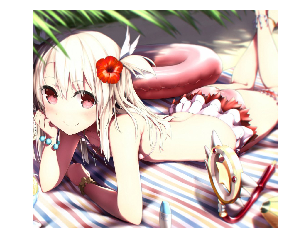

comic book (score = 0.70675)
carousel, carrousel, merry-go-round, roundabout, whirligig (score = 0.05225)
toilet seat (score = 0.01356)
tray (score = 0.01291)
vase (score = 0.01076)

C:/learn/images\timg (1).jpg


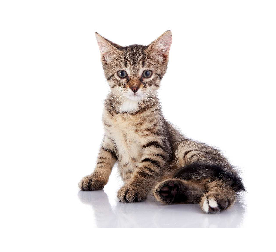

tabby, tabby cat (score = 0.52711)
Egyptian cat (score = 0.28845)
tiger cat (score = 0.10228)
lynx, catamount (score = 0.00828)
carton (score = 0.00078)

C:/learn/images\u=590611378,2742913883&fm=26&gp=0.jpg


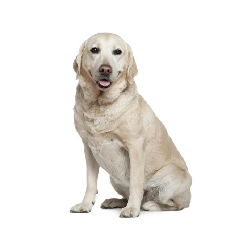

Labrador retriever (score = 0.89805)
golden retriever (score = 0.02183)
Chesapeake Bay retriever (score = 0.00523)
kuvasz (score = 0.00379)
tennis ball (score = 0.00181)



In [ ]:
# 创建一个图来存放Google训练好的模型
with tf.gfile.GFile("C:/learn/inception_model/classify_image_graph_def.pb", "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name="")

with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name("softmax:0")
    # 遍历目录
    for root, dirs, files in os.walk("C:/learn/images"):
        for file in files:
            # 载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root, file), "rb").read()
            predictions = sess.run(softmax_tensor, {"DecodeJpeg/contents:0" : image_data})
            predictions = np.squeeze(predictions) # 把结果转为1维数据
            
            # 打印图片路径及名称
            image_path = os.path.join(root, file)
            print(image_path)
            # 显示图片
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis("off")
            plt.show()
            
            # 排序
            top_k = predictions.argsort()[-5:][::-1]
            node_lookup = NodeLookup()
            for node_id in top_k:
                # 获取分类名称
                human_string = node_lookup.id_to_string(node_id)
                # 获取分类的致信度
                score = predictions[node_id]
                print("%s (score = %.5f)" % (human_string, score))
            print()